## Employee Departure Prediction with Semi-Supervised Learning and SME-Driven Labeling

### Introduction

Predicting employee attrition is vital for improving retention and reducing turnover costs. In this project, we tackle the challenge of predicting which employees are likely to leave the company using **semi-supervised learning**. While the dataset contains rich employee information, it lacks labels.

We are allowed to consult a **Subject Matter Expert (SME) up to 500 times** to obtain labels for a small subset. Using clustering and label propagation, we expand these limited labels and train a supervised model to predict attrition across the workforce. This project demonstrates how combining human expertise with machine learning can yield powerful insights in data-scarce environments.

__Data:__

`https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final/employee_departure_dataset_X.csv`

### Load, inspect and clean the data

In [ ]:
# Step 0: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')
# Settings
sns.set(style="whitegrid")
%matplotlib inline

In [ ]:
# Step 1: Load and inspect the data
X = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final/employee_departure_dataset_X.csv')
y = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final/employee_departure_dataset_y.csv')
print("Data shape:", X.shape)
print("First 5 rows:")
display(X.head())

print(X.dtypes)

Data shape: (500000, 27)
First 5 rows:


,RecordId,Gender,Distance,YearsWorked,TrainingHours,WorkLifeBalance,NumOfProjects,JobInvolvement,TeamSize,MentorshipReceived,...,ProjectComplexity,WorkSatisfactionScore,JobEngagementScore,PhysicalActivityScore,MentalWellbeingScore,DepartmentCode,PreviousSalary,Salary,SelfReview,SupervisorReview
0,100,1,>30miles,7,91,4,14,3,8,1,...,2,3,2,9,5,5,72K,73K,4.0,4.0
1,101,0,~10miles,10,52,5,9,2,10,0,...,1,3,4,8,1,1,62K,64K,4.0,4.0
2,102,0,~10miles,10,80,3,13,3,16,0,...,3,7,2,7,8,5,73K,74K,4.0,2.0
3,103,0,~15miles,5,6,3,15,5,16,0,...,4,6,9,5,5,1,63K,64K,5.0,5.0
4,104,1,~10miles,10,3,2,13,3,18,0,...,3,3,4,4,4,2,60K,64K,4.0,4.0


RecordId                     int64
Gender                       int64
Distance                    object
YearsWorked                  int64
TrainingHours                int64
WorkLifeBalance              int64
NumOfProjects                int64
JobInvolvement               int64
TeamSize                     int64
MentorshipReceived           int64
TechSkillLevel               int64
AttendanceRate             float64
StressLevel                  int64
PeerFeedbackScore            int64
AnnualLeaveDays              int64
Certifications               int64
SkillDevelopmentCourses      int64
ProjectComplexity            int64
WorkSatisfactionScore        int64
JobEngagementScore           int64
PhysicalActivityScore        int64
MentalWellbeingScore         int64
DepartmentCode               int64
PreviousSalary              object
Salary                      object
SelfReview                 float64
SupervisorReview           float64
dtype: object


In [ ]:
print(X['Distance'].unique())

['>30miles' '~10miles' '~15miles' '~20miles' '<5mile' nan]


In [ ]:
X.isnull().sum()

,0
RecordId,0
Gender,0
Distance,508
YearsWorked,0
TrainingHours,0
WorkLifeBalance,0
NumOfProjects,0
JobInvolvement,0
TeamSize,0
MentorshipReceived,0


### Preprocessing the data (Pipelines)

**1. Distance Encoding**: Converted the Distance column such as "<5mile" and "~10miles" into ordinal numeric values (0, 1, 2).

**2. Data Type Conversion**: Converted Gender and DepartmentCode columns to categorical types.

**3. Salary Field Parsing**: Converted Salary and PreviousSalary from strings with "K" into integers (e.g., 65000).

**4. Missing Value Imputation**: Filled missing values in SelfReview and SupervisorReview columns using median values.
Filled missing values in Distance column using mode values.

**5. Feature Engineering**: Created several derived features, such as SalaryGrowthRatio and ReviewConsistency (Difference between self and supervisor reviews).

**6. Dropping Redundant Columns**: Removed RecordId, Salary, and PreviousSalary after feature extraction.

**7. Numeric Feature Imputation & Scaling**: Standardized all numeric features using StandardScaler() for model stability.

In [ ]:
preprocessing_code = """
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

def preprocess_data(X, imputer=None, scaler=None, fit=True):
    # Convert to lowercase and strip spaces (Distance preprocessing must come first!)
    X['Distance'] = X['Distance'].astype(str).str.strip().str.lower()
    X['Distance'] = X['Distance'].map({
        '<5mile': 0,
        '~10miles': 0,
        '~15miles': 1,
        '~20miles': 1,
        '>30miles': 2
    })
    if X['Distance'].isnull().any():
        mode_val = X['Distance'].mode()[0]
        X['Distance'] = X['Distance'].fillna(mode_val)
    X['Distance'] = X['Distance'].astype('int64')  # Ensure it's numeric BEFORE split

    # Convert other columns to proper types
    X['Gender'] = X['Gender'].astype('category')
    X['DepartmentCode'] = X['DepartmentCode'].astype('category')

    # Parse salary columns like "5K" to numeric
    for col in ['Salary', 'PreviousSalary']:
        X[col] = X[col].replace({'\$': '', ',': '', 'K': '*1000'}, regex=True)
        X[col] = X[col].apply(lambda x: eval(x) if isinstance(x, str) else x)
        X[col] = pd.to_numeric(X[col], errors='coerce')

    # Fill Self/Supervisor reviews manually
    for col in ['SelfReview', 'SupervisorReview']:
        X[col] = X[col].fillna(X[col].median())

    # Create derived features
    X['SalaryGrowthRatio'] = (X['Salary'] - X['PreviousSalary']) / (X['PreviousSalary'] + 1)
    X['ReviewConsistency'] = X['SelfReview'] - X['SupervisorReview']
    X['AverageReview'] = (X['SelfReview'] + X['SupervisorReview']) / 2
    X['WorkLoadIndex'] = (X['NumOfProjects'] * X['ProjectComplexity']) / (X['TeamSize'] + 1)

    # Drop unused or raw columns
    X.drop(columns=['RecordId', 'Salary', 'PreviousSalary'],
           errors='ignore', inplace=True)

    # Split numerical and categorical
    numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
    categorical_cols = [col for col in X.columns if col not in numeric_cols]

    # Impute numeric values
    X_numeric = X[numeric_cols]
    if imputer is None and fit:
        imputer = SimpleImputer(strategy='median')
        X_numeric_imputed = pd.DataFrame(imputer.fit_transform(X_numeric), columns=numeric_cols)
    else:
        X_numeric_imputed = pd.DataFrame(imputer.transform(X_numeric), columns=numeric_cols)

    # Scale numeric values
    if scaler is None and fit:
        scaler = StandardScaler()
        X_numeric_scaled = pd.DataFrame(scaler.fit_transform(X_numeric_imputed), columns=numeric_cols)
    else:
        X_numeric_scaled = pd.DataFrame(scaler.transform(X_numeric_imputed), columns=numeric_cols)

    # Combine all features
    X_final = pd.concat([X_numeric_scaled, X[categorical_cols].reset_index(drop=True)], axis=1)

    return X_final, imputer, scaler

"""

# Write the preprocessing function to a Python file
with open("preprocessing.py", "w", encoding="utf-8") as f:
    f.write(preprocessing_code)

print("The file 'preprocessing.py' has been created successfully.")

The file 'preprocessing.py' has been created successfully.


### Standardize features

In [ ]:
from preprocessing import preprocess_data
X_scaled, imputer, scaler = preprocess_data(X, fit=True)
display(X_scaled.head())

,Distance,YearsWorked,TrainingHours,WorkLifeBalance,NumOfProjects,JobInvolvement,TeamSize,MentorshipReceived,TechSkillLevel,AttendanceRate,...,PhysicalActivityScore,MentalWellbeingScore,SelfReview,SupervisorReview,SalaryGrowthRatio,ReviewConsistency,AverageReview,WorkLoadIndex,Gender,DepartmentCode
0,2.037751,-0.001366,1.438248,0.705213,0.728821,0.002158,-0.364801,0.998661,-0.706575,0.835818,...,1.552181,-0.001183,-0.604802,-0.102457,-1.124020,-0.263952,-0.431062,-0.187650,1,5
1,-1.094148,1.604588,0.087179,1.412431,-0.183810,-0.704789,0.000204,-1.001341,-0.706575,0.886669,...,1.164488,-1.550988,-0.604802,-0.102457,0.132320,-0.263952,-0.431062,-0.619927,0,1
2,-1.094148,1.604588,1.057177,-0.002006,0.546294,0.002158,1.095221,-1.001341,-0.706575,-1.633716,...,0.776795,1.161171,-0.604802,-2.219610,-1.137033,1.470119,-2.162213,-0.341675,0,5
3,0.471802,-1.072002,-1.506391,-0.002006,0.911347,1.416051,1.095221,-1.001341,0.000598,0.092974,...,0.001408,-0.001183,0.902614,0.956119,-0.988320,-0.263952,1.300089,-0.108789,0,1
4,-1.094148,1.604588,-1.610319,-0.709224,0.546294,0.002158,1.460227,-1.001341,0.000598,-1.209135,...,-0.386285,-0.388634,-0.604802,-0.102457,2.485661,-0.263952,-0.431062,-0.387201,1,2


### Train/Test split

In [ ]:
# Step 3: Split data — y is only used for final evaluation
X_train_1, X_test_1, _, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train = X_train_1.to_numpy()
X_test = X_test_1.to_numpy()

In [ ]:
# Step 4: SME Class
class SME:
    def __init__(self):
        self.asked = 0
        self.df = self.get()

    def get(self):
        X_raw = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final/employee_departure_dataset_X.csv')
        y_raw = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final/employee_departure_dataset_y.csv')
        X_raw['Left'] = y_raw
        return X_raw

    def ask(self, valuedict):
        self.asked += 1
        if self.asked > 500:
            raise Exception("You have reached the SME query limit.")

        arr = []
        for prop, val in valuedict.items():
            if pd.isna(val):  # skip NaN
                continue
            # Escape single quotes in strings
            if isinstance(val, str):
                val = val.replace("'", "\\'")
                arr.append(f"`{prop}` == '{val}'")
            else:
                arr.append(f"`{prop}` == {val}")

        query = " and ".join(arr)

        try:
            result = self.df.query(query)
        except Exception as e:
            raise Exception(f"Query failed:\n{query}\nError: {e}")

        if len(result) == 0:
            raise Exception("SME cannot determine the answer.")
        return int(result["Left"].mean())


### KMeans clustering

Step 5: KMeans clustering complete.


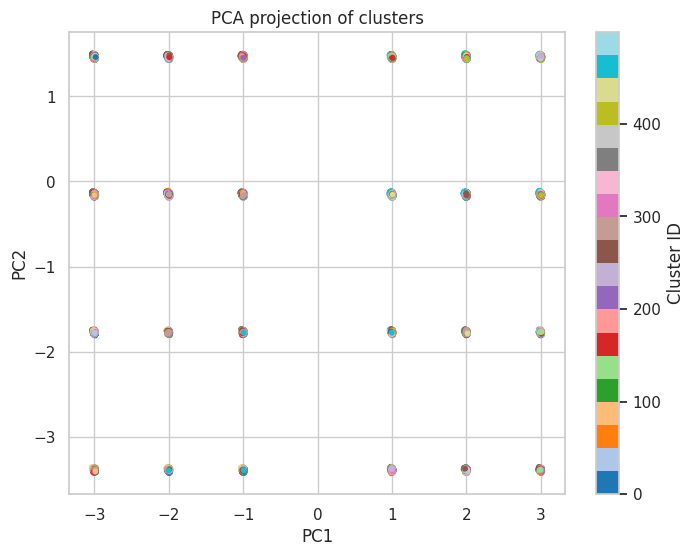

In [ ]:
# Step 5: Cluster with KMeans
k = 500
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(X_train)

# Distance matrix: distance from each sample to its cluster center
X_dist = np.linalg.norm(X_train - kmeans.cluster_centers_[cluster_labels], axis=1)

print("Step 5: KMeans clustering complete.")

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='tab20', s=10)
plt.title("PCA projection of clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Cluster ID')
plt.show()

### Identify 500 representative samples

In [ ]:
# Step 6: Find unique cluster representatives (one per cluster, no duplicates)
selected_indices = set()
closest = []

for i in range(k):
    # Get indices of all samples in the current cluster
    cluster_indices = np.where(cluster_labels == i)[0]
    cluster_distances = X_dist[cluster_indices]

    # Sort by distance to the cluster center (ascending)
    sorted_idx = cluster_indices[np.argsort(cluster_distances)]

    # Select the first non-duplicate sample as the representative
    for idx in sorted_idx:
        if idx not in selected_indices:
            closest.append(idx)
            selected_indices.add(idx)
            break  # Only one representative per cluster

# Load the raw data for SME queries
X_raw = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final/employee_departure_dataset_X.csv')
_, X_raw_train = train_test_split(X_raw, test_size=0.8, random_state=42)
X_raw_train = X_raw_train.reset_index(drop=True)

# Initialize SME
sme = SME()

# Query SME for labels of the selected representative samples
y_representative = []
for idx in closest:
    row_dict = dict(X_raw_train.iloc[idx])
    label = sme.ask(row_dict)
    y_representative.append(label)

y_representative = np.array(y_representative)
print(f"Step 6: SME queried for 500 unique representative points.")


Step 6: SME queried for 500 unique representative points.


In [ ]:
# Review SME query results for a few representative points
for i in range(5):  # Select the first 5 samples to view
    record_id = X_raw_train.iloc[closest[i]]['RecordId']
    sme_label = y_representative[i]
    print(f"Representative sample {i}: RecordId = {record_id}, SME label = {sme_label}")

Representative sample 0: RecordId = 137959, SME label = 1
Representative sample 1: RecordId = 36604, SME label = 1
Representative sample 2: RecordId = 165304, SME label = 1
Representative sample 3: RecordId = 406054, SME label = 1
Representative sample 4: RecordId = 322215, SME label = 0


### Label Propagation with Euclidean Distance
1. For each cluster, selected the top-N samples closest to the cluster center (using Euclidean distance).
2. Assigned them the cluster’s label.
3. Enforcing a maximum number of samples per class to keep balance.

Step 7: Labels propagated with per-cluster top-N Euclidean distance and class cap.
Final class counts: {0: 100000, 1: 100000}


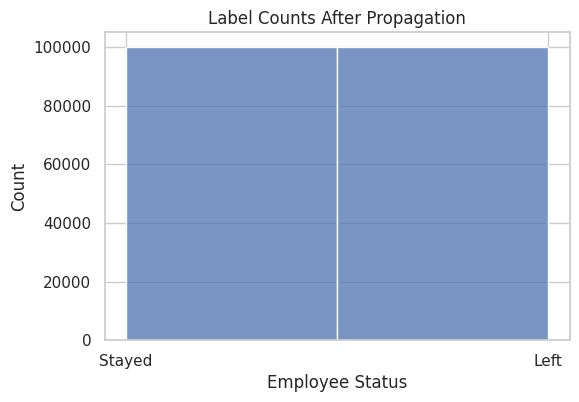

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

# Initialize all propagated labels as -1 (unknown)
y_propagated = np.full(len(X_train), -1)

# Set maximum number of samples to propagate per class
max_per_class = 100000
class_counts = {0: 0, 1: 0}

# Number of closest samples to propagate in each cluster
top_n_per_cluster = 700

# Compute Euclidean distance matrix between all training samples and cluster centers
# (smaller value means more similar)
eu_dist_matrix = euclidean_distances(X_train, kmeans.cluster_centers_)

for i in range(k):
    label = y_representative[i]  # The label provided by SME for the current cluster

    # Skip if the max sample count for this class has been reached
    if class_counts[label] >= max_per_class:
        continue

    # Get indices of samples in the current cluster
    in_cluster = (cluster_labels == i)
    cluster_indices = np.where(in_cluster)[0]

    # Extract corresponding distances (smaller is closer)
    distances = eu_dist_matrix[cluster_indices, i]
    sorted_idx = cluster_indices[np.argsort(distances)]  # Sort by distance

    # Select top-N closest samples to the cluster center
    top_indices = sorted_idx[:top_n_per_cluster]

    # Check how many samples can still be added for this class
    available_slots = max_per_class - class_counts[label]
    if len(top_indices) > available_slots:
        top_indices = top_indices[:available_slots]

    # Assign propagated labels
    y_propagated[top_indices] = label
    class_counts[label] += len(top_indices)

print("Step 7: Labels propagated with per-cluster top-N Euclidean distance and class cap.")
print(f"Final class counts: {class_counts}")

# visualisation
plt.figure(figsize=(6, 4))
sns.histplot(y_propagated[y_propagated != -1], bins=2)
plt.title("Label Counts After Propagation")
plt.xlabel("Employee Status")
plt.ylabel("Count")
plt.xticks([0, 1], ['Stayed', 'Left'])
plt.show()


### Train Logistic Regression with GridSearchCV

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight

# Take the labeled data
mask = y_propagated != -1
X_labeled = X_train[mask]
y_labeled = y_propagated[mask]

# handle the category imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_labeled)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# ParamGrid
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

# Initiate
lr_clf = LogisticRegression(max_iter=1000, class_weight=class_weight_dict, random_state=42)

# GridSearch
grid_search_lr = GridSearchCV(estimator=lr_clf, param_grid=param_grid_lr, cv=5,
                              scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_lr.fit(X_labeled, y_labeled)

print("Best parameters (Logistic Regression):", grid_search_lr.best_params_)
print("Best CV accuracy (Logistic Regression):", grid_search_lr.best_score_)

best_lr = grid_search_lr.best_estimator_
best_lr.fit(X_labeled, y_labeled)
print("Logistic Regression model trained on all labeled data.")


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters (Logistic Regression): {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV accuracy (Logistic Regression): 0.589205
Logistic Regression model trained on all labeled data.


### Train Random Forest with GridSearchCV

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# ParamGrid
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced']  # handle imbalance
}

rf_clf = RandomForestClassifier(random_state=42)

grid_search_rf = GridSearchCV(estimator=rf_clf, param_grid=param_grid_rf, cv=5,
                              scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_rf.fit(X_labeled, y_labeled)

print("Best parameters (Random Forest):", grid_search_rf.best_params_)
print("Best CV accuracy (Random Forest):", grid_search_rf.best_score_)

best_rf = grid_search_rf.best_estimator_
best_rf.fit(X_labeled, y_labeled)
print("Random Forest model trained on all labeled data.")


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters (Random Forest): {'class_weight': 'balanced', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 200}
Best CV accuracy (Random Forest): 0.6634899999999999
Random Forest model trained on all labeled data.


### Train XGBoost classifier (Cross Validation)

In [ ]:
# Step 8: Train XGBoost classifier on labeled data with GridSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.8, 0.9]
}

mask = y_propagated != -1
X_labeled = X_train[mask]
y_labeled = y_propagated[mask]

# Calculate the scale_pos_weight to handle class imbalance
scale_pos_weight = sum(y_labeled == 0) / sum(y_labeled == 1)

# Initialize the XGBoost classifier
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                        scale_pos_weight=scale_pos_weight, random_state=42)

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=5,
                           scoring='accuracy', n_jobs=-1, verbose=1)

# Fit GridSearchCV to the data
grid_search.fit(X_labeled, y_labeled)

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: ", grid_search.best_score_)

# Fit the best model on all labeled data
best_xgb_clf = grid_search.best_estimator_
best_xgb_clf.fit(X_labeled, y_labeled)
print("XGBoost model trained on all labeled data.")
neg = sum(y_labeled == 0)
pos = sum(y_labeled == 1)
scale_pos_weight = neg / pos
print(f"Negative samples: {neg}")
print(f"Positive samples: {pos}")
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.7}
Best cross-validation accuracy:  0.7373900000000001
XGBoost model trained on all labeled data.
Negative samples: 100000
Positive samples: 100000
scale_pos_weight: 1.00


### Save the model, scaler and imputer

In [ ]:
import joblib

# save models
joblib.dump(best_xgb_clf, 'semisupervised_xgb_model.joblib')
joblib.dump(best_lr, 'semisupervised_lr_model.joblib')
joblib.dump(best_rf, 'semisupervised_rf_model.joblib')

# Save Preprocessor
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(imputer, 'imputer.joblib')

print("All models and preprocessors saved.")


All models and preprocessors saved.


Metrics Selection for Predicting Employee Departure
Employee departure prediction often involves imbalanced data, where the majority of employees stay. Therefore, standard accuracy is not sufficient. The following metrics are recommended:

Precision (for 'Left') Of all employees predicted to leave, how many actually left? Helps avoid false positives.
Recall (for 'Left') Of all employees who actually left, how many did we correctly identify? Helps avoid false negatives.
F1-Score The harmonic mean of precision and recall.

# **CONCLUSION**

In this project, we loaded, inspected and cleaned the data. And then we do K-Means clustering and ask SME query for the labels. Later, we do label propogation by selecting top nearest samples. In the end, we used 3 models, such as LR, RF, XGBoost to train the data and saved the models.

Only 500 truly labeled samples were available from SME, which is extremely limited compared to the total dataset of 500,000 records. Although semi-supervised techniques like label propagation were used to expand the labeled set, such methods are highly sensitive to the quality and distribution of the initial labels.

Given the massive imbalance between labeled and unlabeled data, and the potential inaccuracies introduced during propagation, the model's ability to generalize suffers considerably. This limitation is likely a key reason why even optimized models performed only marginally better than random guessing.

Next Steps
Improve feature engineering further:
Add domain-informed features (e.g., trend in reviews, salary change, project volatility).

Improve label quality and coverage:
Label more representative samples or get SME-labeled data beyond the 500 seeds.